In [1]:
import sys
import yaml
import numpy as np
import matplotlib.pyplot as plt

from math import pi
from pathlib import Path 
from tabulate import tabulate
from shapely import Point, MultiPoint, LineString, affinity

In [2]:
file = Path().resolve()
parent, root = file.parent, file.parents[1]

# add the location of the root folder (zeroheliumkit) to the PATH
sys.path.append(str(root))

# Additionally remove the current file's directory from sys.path
try:
    sys.path.remove(str(parent))
except ValueError: # Already removed
    pass

In [48]:
from zeroheliumkit import Entity, Structure
from zeroheliumkit.src.basics import Meander, Rectangle
from zeroheliumkit.src.geometries import *
from zeroheliumkit.src.settings import *
from zeroheliumkit.helpers.resonator_calc import *

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [96]:
plot_config = {"gnd": BLUE,
               "open": ORANGE,
               "temp": WHITE,
               "island": YELLOW2,
               "anchors": RED}

In [39]:
def construct_resonator_skeletone(params: dict) -> LineString:
    g_params = params["geometry"]
    d_a = g_params['coupling_length']
    d_w = g_params['distance_from_waveguide']
    d_l = g_params['openend_length']
    d_R = g_params['radius']
    n = g_params['num']
    w = g_params["w"]
    g = g_params["g"]

    cpw_params = CPW_params(params["eps"], w * um, g * um, params["substrate_h"] * um, 0)
    cpw_params.resonator_length(params["frequency"] * GHz, params["type"], 0)
    length = cpw_params.length/um
    
    d_b = (length - (d_l + d_a + d_w + d_R * (3 * pi/2 + 2 * pi * n + 1)))/(2 * n + 1)
    if d_b < 0:
        raise Exception("Incorrect geometry input. Choose different 'bending_radius', 'coupling_length', 'openend_length' or 'num_wiggles'")

    sk = Entity()
    sk.add_line(LineString([(0, 0), (0, d_l)]))
    sk.add_line(ArcLine(-d_R, 0, d_R, 0, 90, 20))
    sk.add_line(LineString([(0, 0), (-d_a, 0)]))
    sk.add_line(ArcLine(0, -d_R, d_R, 90, 180, 20))
    sk.add_line(LineString([(0, 0), (0, -d_w)]))
    sk.add_line(ArcLine(d_R, 0, d_R, 180, 270, 20))
    sk.add_line(LineString([(0, 0), (d_b/2, 0)]), ignore_crossing=True)
    for _ in range(n):
        sk.add_line(Meander(d_b, d_R, direction=-90), ignore_crossing=True)
    sk.add_line(LineString([(0, 0), (d_b/2 + d_R, 0)]))

    return sk.skeletone

-------  ----------  ---------  -------  ---  -------  --------------  ------  -------
f0, GHz  length, mm  width, um  gap, um  eps  eps_eff  impedance, Ohm  L, nH   C, pF
7.7      3.97        8.0        4.5      11   6.0      50.89           415.79  160.555
-------  ----------  ---------  -------  ---  -------  --------------  ------  -------


<Axes: >

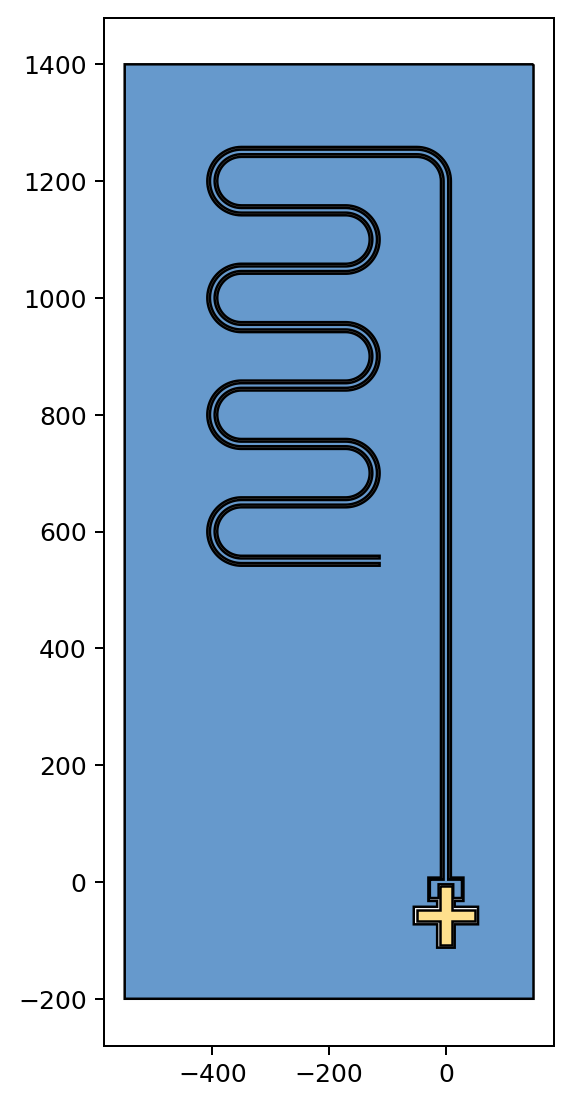

In [104]:
with open('params.yaml', 'r') as file:
    params = yaml.safe_load(file)

gp = params["resonator"]["geometry"]

resonator_sk = construct_resonator_skeletone(params["resonator"])

resonator = Structure()
resonator.add_line(resonator_sk)
resonator.buffer_line("open", gp["w"]/2 + gp["g"], cap_style="square", join_style="mitre")
resonator.add_line(LineString([(0, 0), (10, 0)]))
resonator.buffer_line("temp", gp["w"]/2, cap_style="square", join_style="mitre")
resonator.add_anchor([Anchor((0,0), -90, "end")])

island = Structure()
island.add_layer("island", Rectangle(100, 20, (0,0)))
island.add_polygon("island", Rectangle(20, 100, (0,0)))
island.add_layer("open", island.island.buffer(5, join_style='mitre'))
island.add_anchor([Anchor((0, 57.5), -90, "isl")])

resonator.append(island, anchoring=("end", "isl"))
resonator.add_polygon("open", Rectangle(60, 40, (0, 45 - 57.5)))
resonator.cut_polygon("open", Rectangle(15, 30, (20, 45 - 57.5)))
resonator.cut_polygon("open", Rectangle(15, 30, (-20, 45 - 57.5)))
resonator.cut_polygon("open", Rectangle(55, 8, (0, 0)))
resonator.cut_polygon("open", resonator.temp)
resonator.remove_layer("temp")
resonator.remove_anchor(["isl", "end"])

resonator.add_layer("gnd", Rectangle(700, 1600, (-200, 600)))
resonator.cut_polygon("gnd", resonator.open)
resonator.remove_layer("open")

resonator.quickplot(plot_config)